# HERE

https://medium.com/@balantekinbgr/deep-learning-and-nlp-for-text-analytics-step-by-step-guide-to-building-a-text-classification-b35349e6cdb1

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sklearn.model_selection import train_test_split

#!pip install contractions 
from contractions import fix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# Start Spark
spark = (
    SparkSession.builder
    .appName("AmazonReviewsSample")
    .master("local[*]")
    .getOrCreate()
)

In [6]:
df = spark.read.parquet('aita_train.parquet')

In [8]:
df.count()

60709

In [10]:
df.columns

['id', 'title', 'text', 'verdict', 'comment1', 'comment2', 'score']

    so 60709 rows and 6 columns but honestly only need 3 colums [title, text, verdict]

In [21]:
filtered_df = df.select('title', 'text', 'verdict', 'score')

In [15]:
verdict_counts = (df
                  .groupby('verdict')
                  .agg(
                      F.count('*').alias('verdict_count'))
                  .orderBy('verdict_count')
                  .toPandas()
                 )

In [16]:
verdict_counts

,verdict,verdict_count
0,esh,1008
1,nah,1231
2,yta,8209
3,nta,50261


/tmp/ipykernel_120388/2147903225.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


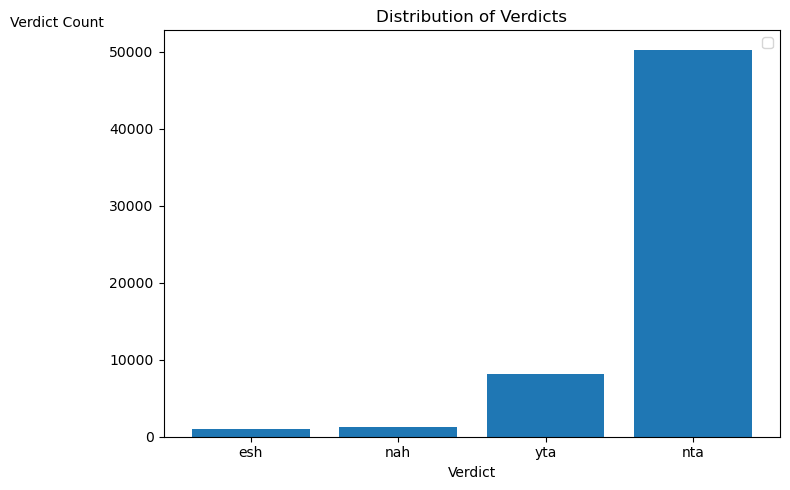

In [19]:
plt.figure(figsize=(8,5))
plt.bar(verdict_counts['verdict'], verdict_counts['verdict_count'])

plt.title("Distribution of Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Verdict Count", rotation=0, loc="top")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
labels = verdict_counts['verdict']  # convert verdict to numeric labels (0–3)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights

In [27]:
(df.select('text').limit(20).show(vertical = True, truncate = False, ))

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_pd = filtered_df.toPandas()

In [99]:
full_text_df = df_pd['title'] + ' ' + df_pd['text']
# make binary classification
# map (yta and esh: 1, nta and nah: 0)

verdict_df = df_pd['verdict'].map({
    'esh': '1',
    'nah': '0',
    'yta': '1',
    'nta': '0'
})

In [106]:
verdict_count = verdict_df.value_counts()

/tmp/ipykernel_120388/120847911.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


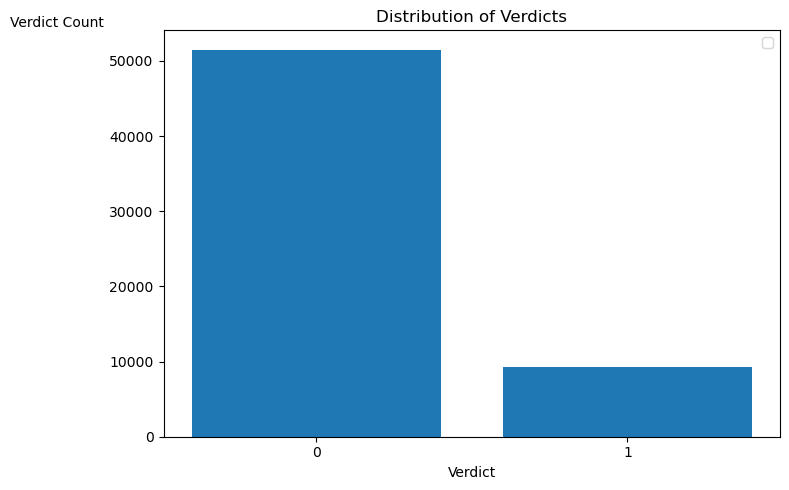

In [109]:
plt.figure(figsize=(8,5))
plt.bar(verdict_count.index, verdict_count.values)

plt.title("Distribution of Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Verdict Count", rotation=0, loc="top")
plt.legend()
plt.tight_layout()
plt.show()


In [95]:
# Preprocessing Steps:

def TextClener(text):
    stop_words_set = set(stopwords.words('english'))
    
    # make lowercase and remove contractions
    text = fix(text.lower())
    # remove punctuations
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # tokenize works
    text = word_tokenize(text)
    # lemmatize non-stop words
    text = [WordNetLemmatizer().lemmatize(word) for word in text \
            if word not in stop_words_set]
    text = ' '.join(text).strip()
    return text

In [96]:
sample = full_text_df.apply(TextClener)

In [98]:
print(sample)

0        aita angry mother going phone recently talking...
1        aita sharing toothbrush husband christmas mom ...
2        wibta wanting go trip alone post anywhere else...
3        aita trying cheer coworker lost father child n...
4        aita billing bf pilot instructor rating teach ...
                               ...                        
60704    aita asking family restart business great gran...
60705    aita buying brother game birthday money f birt...
60706    wibta take mother court college fund already p...
60707    aita refusing kiss girlfriend finding kiss cat...
60708    aita visiting parent newborn context baby janu...
Length: 60709, dtype: object


In [90]:
set(stopwords.words('english'))

NameError: name 'stopwords' is not defined

# SMALL BERT THAT I DON'T KNOW HOW IT WORKS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sklearn.model_selection import train_test_split

!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification

from datasets import Dataset
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm

x_train = train_df['text']
x_yal = val_df['text']
x_test = test_df['text']

y_train = train_df['verdict']
y_yal = val_df['verdict']
y_test = test_df['verdict']

In [43]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids','attention_mask','label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)
test_ds.set_format(type='torch', columns=columns)


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # fast to fine-tune

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

NameError: name 'Dataset' is not defined